# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'axes.linewidth': 1,
      'axes.labelpad': 6,
      'xtick.major.pad': 10,
      'xtick.major.width': 1,
      'ytick.major.width': 1,
      'lines.linewidth': 1,
      'font.size': 12,
      'axes.titlesize': 12,
      'axes.labelsize': 12,
      'xtick.labelsize': 12,
      'ytick.labelsize': 12,
      'legend.title_fontsize': 11,
      'legend.fontsize': 11,
      'figure.titlesize': 12,
      'figure.dpi': 72 * 3,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures', 'sfp_model', 'results_1D')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
lr = 0.005
max_epoch = 8000

In [3]:
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
voxels='pRFcenter'

# eccentricity bin information
e1, e2=0.5, 4
enum=7
enum_range=range(7) if enum==7 else range(3) 
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
broderick_bin_list, broderick_bin_labels = tuning.get_bin_labels(1, 12, enum=11)


a = [3,2,0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))


# Load the data and model parameters

## NSD data: data, fitting results, precision

In [6]:
# NSD data
f, m = [], []
for subj, roi in itertools.product(nsd_subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))
nsd_subj_df = utils.load_dataframes(f)
nsd_subj_df = nsd_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
# NSD fitting results
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(nsd_subj_list, roi_list, enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', 'corrected', file_name))
nsd_tuning_df = tuning.load_all_models(pt_file_list, *args)

# NSD precision data
file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 'corrected',
                     f'precision-v_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

### Merge all the dataframes and fit a line to the weighted mean

In [7]:

nsd_tuning_with_precision_df = nsd_tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
nsd_tuning_with_precision_df['pp'] = 1/ nsd_tuning_with_precision_df['mode']
nsd_fit_df = vis1D.fit_line_to_weighted_mean(nsd_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

## Broderick data: data, fitting results, precision

In [8]:
# Broderick data
f, m = [], []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = f'tfunc-uncorrected_e1-1_e2-12_nbin-11_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'before_w_a_correction', 'dataframes', 'broderick', 'binned', file_name))
broderick_subj_df = utils.load_dataframes(f)
broderick_subj_df = broderick_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

# Broderick fitting results
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
## drop the last bin data to avoid edge effects in the fitting
for subj, roi, curbin, stim_class in itertools.product(broderick_subj_list, ['V1'], range(10), ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'tfunc-uncorrected_model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-1_e2-12_nbin-11_curbin-{curbin}_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'before_w_a_correction', 'sfp_model', 'results_1D', 'broderick', file_name))
broderick_tuning_df = tuning.load_all_models(pt_file_list, *args)

# precision
file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    f = os.path.join(output_dir, 'before_w_a_correction', 'dataframes', 'broderick', 'precision', 
                     f'precision-v_dset-broderick_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [9]:
broderick_tuning_with_precision_df = broderick_tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
broderick_tuning_with_precision_df['pp'] = 1/ broderick_tuning_with_precision_df['mode']
broderick_fit_df = vis1D.fit_line_to_weighted_mean(broderick_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

## Merge the two datasets

In [10]:
# categorize based on dset and goal
broderick_tuning_with_precision_df['dset_type'] = 'Broderick et al. V1'
broderick_fit_df['dset_type'] = 'Broderick et al. V1'
broderick_tuning_with_precision_df['goal'] = 'Replication'
broderick_fit_df['goal'] = 'Replication'

nsd_tuning_with_precision_df['dset_type'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_fit_df['dset_type'] = nsd_fit_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_tuning_with_precision_df['goal'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: 'Replication' if x == 'V1' else 'Extension')
nsd_fit_df['goal'] = nsd_fit_df['vroinames'].apply(lambda x: 'Replication' if x == 'V1' else 'Extension')

tmp = nsd_tuning_with_precision_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
nsd_tuning_with_precision_df = pd.concat((tmp, nsd_tuning_with_precision_df), axis=0)

tmp = nsd_fit_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
nsd_fit_df = pd.concat((tmp, nsd_fit_df), axis=0)

tuning_with_precision_df = pd.concat((broderick_tuning_with_precision_df, 
                                      nsd_tuning_with_precision_df), axis=0)
fit_df = pd.concat((broderick_fit_df, nsd_fit_df), axis=0)

# Plot tuning curves for NSD V1, V2, V3

(<Figure size 1404x561.6 with 3 Axes>,
 array([<AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>], dtype=object))

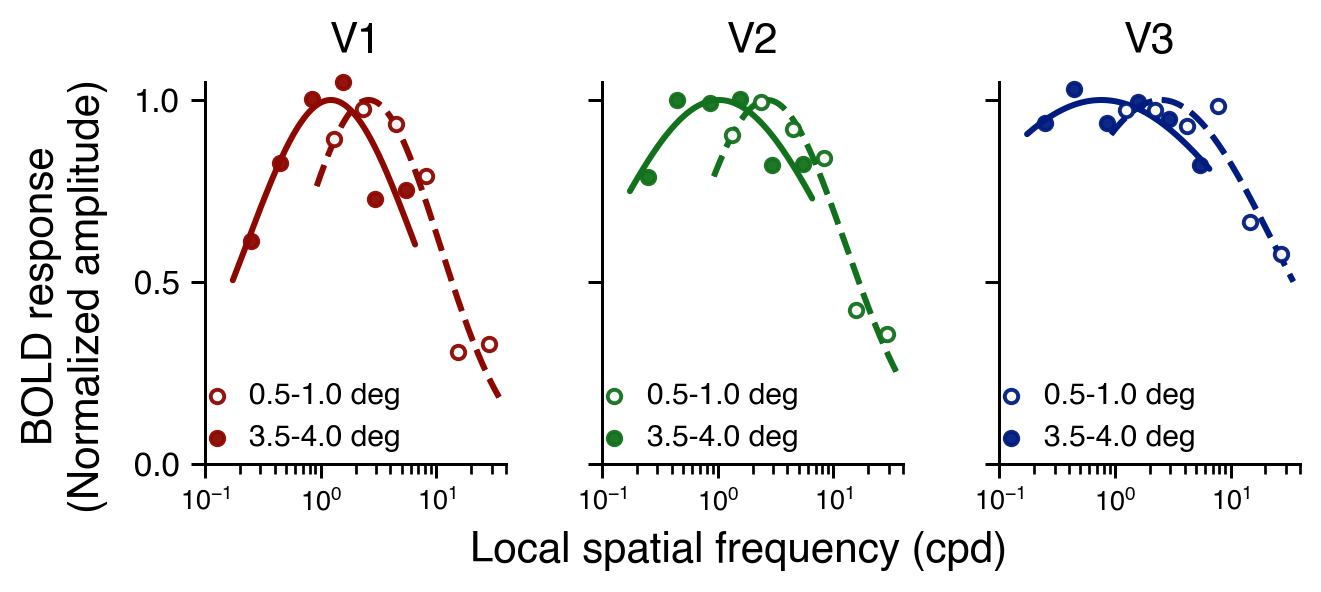

In [13]:
bins_to_plot = [bin_labels[k] for k in [0,6]]
vis1D.plot_tuning_curves_NSD(nsd_subj_df, nsd_tuning_df, subj='subj06', 
                             bins_to_plot=bins_to_plot, pal=roi_pal[1:], 
                             save_path=None)

# Plot preferred period as function of eccentricity

In [12]:
# Extend NSD V1 line up to 10 deg
ecc_max = fit_df.query('dset_type == "Broderick et al. V1"').ecc.max()
tmp_fit_df = fit_df.query('dset_type == "NSD V1" & goal == "Replication" & ecc == 0')
coeff = tmp_fit_df['coefficient'].iloc[0].tolist()
tmp_fit_df['ecc'] = ecc_max
tmp_fit_df['fitted'] = coeff[0] * ecc_max + coeff[1]
fit_df = pd.concat((fit_df, tmp_fit_df), axis=0)

In [23]:
fit_df.groupby(['dset_type','goal']).mean()

ecc  weighted_mean    fitted
dset_type           goal                                          
Broderick et al. V1 Replication  5.454545       1.001934  0.984960
NSD V1              Extension    1.968750       0.466795  0.451331
                    Replication  2.916667       0.445567  0.595440
NSD V2              Extension    1.968750       0.547868  0.537432
NSD V3              Extension    1.968750       0.455922  0.432509

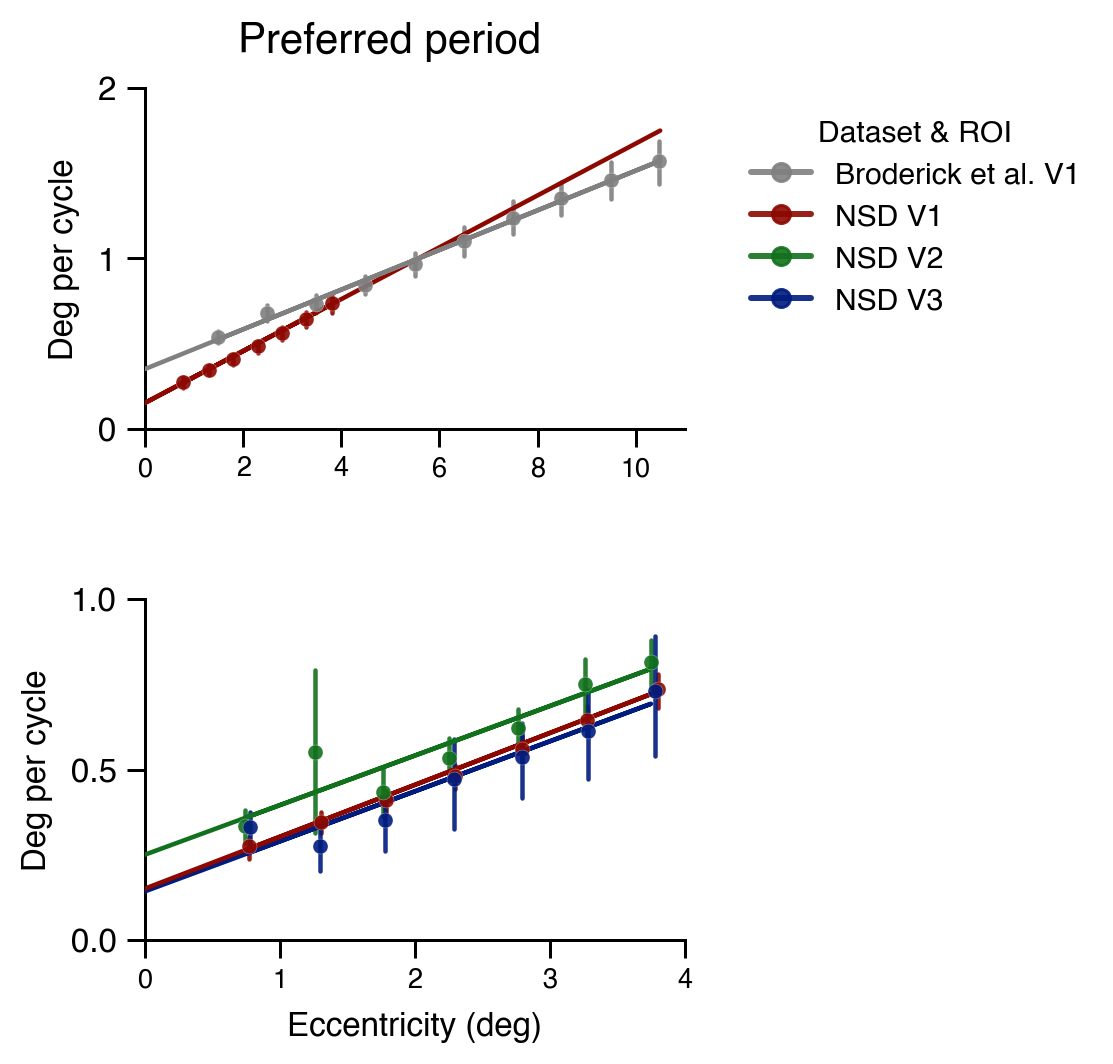

In [14]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, fit_df=fit_df, 
                                row='goal', row_order=['Replication','Extension'], 
                                preferred_period='pp', precision='precision', hue='dset_type', 
                                hue_order=['Broderick et al. V1', 'NSD V1','NSD V2','NSD V3'], lgd_title='Dataset & ROI',
                                pal=roi_pal,
                                suptitle='Preferred period',
                                save_path=None)

# Plot Bandwidth as function of eccentricity

In [15]:
tuning_with_precision_df['fwhm'] = tuning_with_precision_df['sigma']*2.335
fit_bandwidth_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'fwhm', 'precision', groupby=['dset_type','goal'])

tmp_fit_df = fit_bandwidth_df.query('dset_type == "NSD V1" & goal == "Replication" & ecc == 0')
fit_bandwidth_df = pd.concat((fit_bandwidth_df, tmp_fit_df), axis=0)


In [27]:
utils.calculate_weighted_mean(tuning_with_precision_df, ['fwhm'], 'precision', groupby=['dset_type','goal'])

,dset_type,goal,fwhm
0,Broderick et al. V1,Replication,5.594963
1,NSD V1,Extension,5.254613
2,NSD V1,Replication,5.254613
3,NSD V2,Extension,8.088922
4,NSD V3,Extension,9.867018


In [21]:
fit_bandwidth_df

,dset_type,goal,ecc,weighted_mean,coefficient,fitted
0,NSD V3,Extension,0.75,10.805302,"[-0.41368605333419384, 10.797811998111415]",10.487547
1,NSD V3,Extension,1.25,10.279558,"[-0.41368605333419384, 10.797811998111415]",10.280704
2,NSD V3,Extension,1.75,9.938002,"[-0.41368605333419384, 10.797811998111415]",10.073861
3,NSD V3,Extension,2.25,9.925717,"[-0.41368605333419384, 10.797811998111415]",9.867018
4,NSD V3,Extension,2.75,8.992876,"[-0.41368605333419384, 10.797811998111415]",9.660175
5,NSD V3,Extension,3.25,9.254477,"[-0.41368605333419384, 10.797811998111415]",9.453332
6,NSD V3,Extension,3.75,9.873196,"[-0.41368605333419384, 10.797811998111415]",9.246489
7,NSD V2,Extension,0.75,8.877697,"[-0.8669751174874901, 10.039615762762745]",9.389384
8,NSD V2,Extension,1.25,9.852301,"[-0.8669751174874901, 10.039615762762745]",8.955897
9,NSD V2,Extension,1.75,8.817466,"[-0.8669751174874901, 10.039615762762745]",8.522409


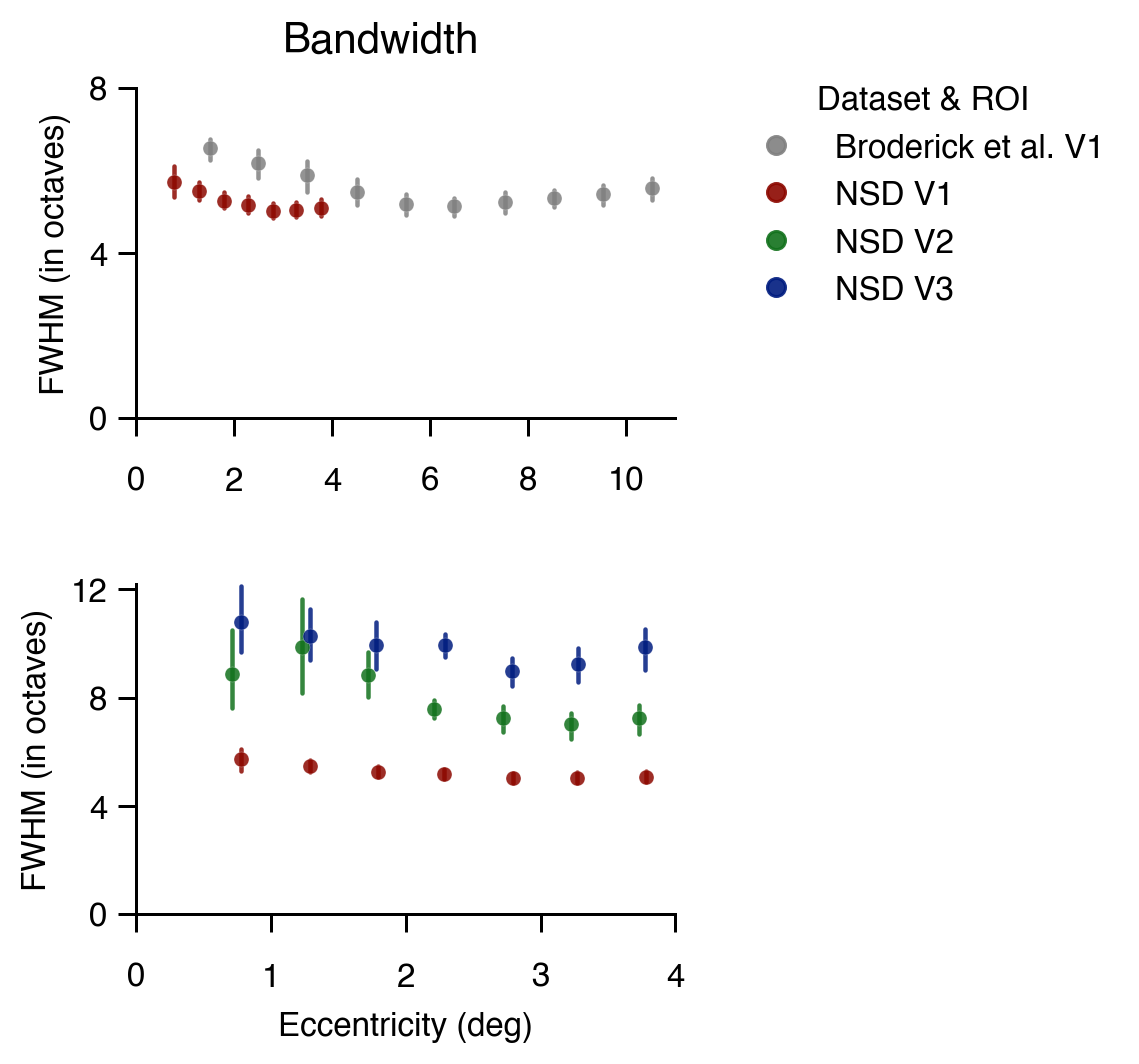

In [36]:
vis1D.plot_bandwidth_in_octaves(df=tuning_with_precision_df, fit_df=None,
                               bandwidth='fwhm', precision='precision', 
                               row='goal', row_order=['Replication','Extension'], 
                               hue='dset_type', 
                                hue_order=['Broderick et al. V1', 'NSD V1','NSD V2','NSD V3'],
                                lgd_title='Dataset & ROI',
                                pal=roi_pal,
                                suptitle='Bandwidth',
                               save_path=None)